## PyTorch installation
Refer to Project 0 for instructions how to install all required libraries below using conda

In [1]:
import os
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt # plotting
import numpy 
import numpy as np
from torch import nn, optim
import torch.nn.functional as F

In [2]:
#check the version of the GPU
from pynvml import *
nvmlInit()
 
deviceCount = nvmlDeviceGetCount()
print(deviceCount)
 
for i in range(deviceCount):
    handle = nvmlDeviceGetHandleByIndex(i)
    print ("Device", i, ":", nvmlDeviceGetName(handle))


1
Device 0 : b'NVIDIA GeForce RTX 3080 Ti'


## Download the Fashion MNIST dataset

And convert it into a format (a tensor) that pytorch understands. A tensor can be thought of as matrix (you get to define the dimensions).

Feed the raw images and their labels into a DataLoader that will serve them up in batches to train the model.

In [3]:
# Define a transform for the data
transform = transforms.Compose([transforms.ToTensor()])

# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
'''
#separate the training set into train and validation
train_size = int(0.8 * len(trainset))
test_size = len(trainset) - train_size
trainset, valset = torch.utils.data.random_split(trainset, [train_size, test_size])
valloader  = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)
'''
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)


# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

# 1. Notebook is able to execute completely the sample code

# 2.Notebook shows evidence of being able to train on the CPU (or GPU)

In [4]:
torch.cuda.is_available()
device = torch.device('cuda:0')

In [5]:
torch.cuda.is_available()

True

## View a sample image and label
We need to reshape the tensor and feed those pixels into a display library

Label of image tensor(4)
(1, 28, 28)


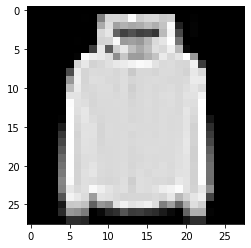

In [6]:
tensor_image, label = next(iter(trainloader)) # returns a batch of images
print("Label of image", label[0])
first_image = numpy.array(tensor_image, dtype='float')[0] # get the first image in the batch
print(first_image.shape)
pixels = first_image.reshape((28, 28))
pixels.shape
plt.imshow(pixels, cmap='gray')
plt.show()

## Define your model
We will have three hidden layers, an input later, and then an output layer. All nodes are Linear nodes (using linear activation).

The input layer takes 784 == 28x28 features, corresponding to our greyscale input images.
The three hidden layers have 256, 128, and 64 neurons respectively; each previous layer's neurons all feed into each neuron in the next layer ("fully connected").
The final layer has ten neurons, one representing each of the ten possible classes for this model.

Under the forward method, we define the activation function for each later: we're using ReLu for all the hidden layers. In the last layer, we're switching to softmax so we can get the probabilities for each class.

In [7]:


# Define your network architecture here
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.softmax(self.fc4(x), dim=1)
        
        return x


# 3. Correctly generates a graph of the training and validation loss curves overlaid

## Training the model
We choose a learning rate (lr) and some number of epochs, with the goal that the loss is going down each epoch until model convergence on the minimum loss (estimated).

In [8]:
# Create the custom network above, define the loss criterion, and choose an optimizer to learn weights
model = Classifier()
model = model.to(device)
loss_criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.3)

# Train the network here
epochs = 50

# This two lists is used in graphing.
epochs_training_loss = np.array([], dtype='float64')
epochs_val_loss = np.array([], dtype='float64')

for e in range(epochs):
    print("In epoch", e)
    running_loss = 0
    val_running_loss = 0
    model.train()
    for images, labels in trainloader: # processing one batch at a time
        images, labels = images.to(device),labels.to(device)
        predictions = model(images) # predict labels
        loss = loss_criterion(predictions, labels) # calculate the loss
        
        # BACK PROPAGATION OF LOSS to generate updated weights
        optimizer.zero_grad() # pytorch accumulates gradients from previous backwards
                              # passes by default -- we want to zero them out;
                              # you can read online why they have this implementation choice
        loss.backward() # compute gradients by using the predictions' grad_fn
                        # that was passed to loss_criterion() above -- this is how it
                        # knows what model parameters need updating eventually
                        # (this is confusing IMO and not obvious to those used to OOP)
        optimizer.step() # using gradients just calculated for model parameters, 
                         # update the weights via the optimizer (which was init with those 
                         # model parameters)
        
        running_loss += loss.item()
    print(f"\tTraining loss: {running_loss/len(trainloader)}")
    model.eval()# Turn off the model training, begin evaluate
    #for images, labels in valloader:                   when consider the testset into validation and test
    for images, labels in testloader:
        # Put the data into GPU
        images, labels = images.to(device), labels.to(device)
        predictions = model(images) # predict labels
        loss_val = loss_criterion(predictions, labels) # calculate the loss
        val_running_loss += loss_val.item()
    
    epochs_training_loss = np.append(epochs_training_loss, running_loss/len(trainloader))
    epochs_val_loss = np.append(epochs_val_loss, val_running_loss/len(testloader))
    print(f"\tValidation loss: {val_running_loss/len(testloader)}")

In epoch 0
	Training loss: 1.8858906739810382
	Validation loss: 1.71321488869418
In epoch 1
	Training loss: 1.7160822151820543
	Validation loss: 1.7293530262199936
In epoch 2
	Training loss: 1.698003538127647
	Validation loss: 1.722241693241581
In epoch 3
	Training loss: 1.6888829753088799
	Validation loss: 1.7052380476787592
In epoch 4
	Training loss: 1.6799844023007064
	Validation loss: 1.6947394730938468
In epoch 5
	Training loss: 1.67444225389566
	Validation loss: 1.6749569511717293
In epoch 6
	Training loss: 1.6698659208537674
	Validation loss: 1.6714796830134786
In epoch 7
	Training loss: 1.6677227241398176
	Validation loss: 1.6792283301140851
In epoch 8
	Training loss: 1.6659866061800324
	Validation loss: 1.6871404389666904
In epoch 9
	Training loss: 1.6640548960232278
	Validation loss: 1.6790792167566384
In epoch 10
	Training loss: 1.6609886447503877
	Validation loss: 1.694714645671237
In epoch 11
	Training loss: 1.6597422630802146
	Validation loss: 1.66698644950891
In epoch 12

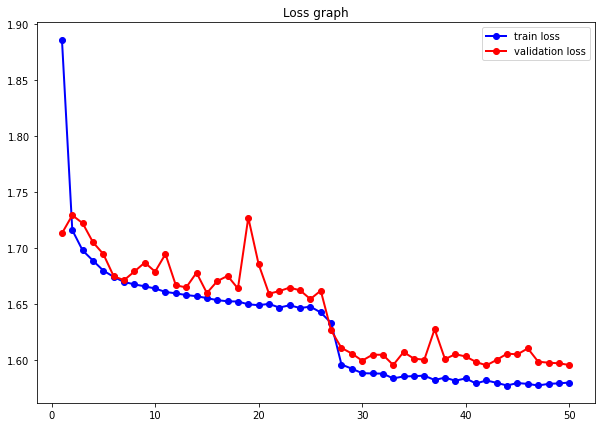

In [9]:
#draw the graph
plt.figure(figsize=(10,7),facecolor='w')
plt.plot(np.array(range(epochs)) + 1.,epochs_training_loss,'o-b',label='train loss',lw =2)
plt.plot(np.array(range(epochs)) + 1.,epochs_val_loss,'o-r',label='validation loss',lw =2)
plt.title('Loss graph')
plt.legend()

## Making predictions
Once we've trained the model, we can grab an image and pull out information about its predicted class.

Target label of image tensor(7)
(1, 28, 28)


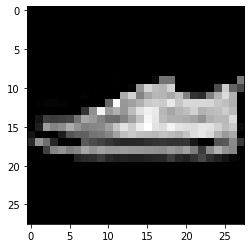

tensor([[3.2315e-37, 1.7155e-20, 1.9109e-25, 1.5711e-16, 1.2415e-27, 5.2732e-25,
         0.0000e+00, 1.0000e+00, 2.3066e-22, 3.5721e-30]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
max_prob 1.0
Predicted label 7


In [10]:
# Test the trained model
tensor_image, label = next(iter(testloader)) # returns a batch of images
print("Target label of image", label[0])
first_image = numpy.array(tensor_image, dtype='float')[0] # get the first image in the batch
print(first_image.shape)
pixels = first_image.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()

prediction = model(tensor_image[0].to(device))
print(prediction)
prediction = prediction.detach().cpu().numpy()
max_prob = max(list(numpy.array(prediction)[0]))
print('max_prob', max_prob)
predicted_label = list(prediction[0]).index(max_prob)
print("Predicted label", predicted_label)

# 4. In a paragraph, discussion of training vs validation loss for this dataset

In our dataset, we trained for 50 epochs.Both the training and validation loss decreased over the 30 epochs run. We expect them to decrease since we are using gradient descent to update the weights to reduce the loss. Since the validation loss is close to the training loss, this means that the model is generalizing to the data - it is able to make good predictions on data it has not seen yet. Then with epoch increases, the training loss decreases, and the validation loss increases. This means the model start overfitting,which means the validation loss diverge from the training loss - as the loss reduces for the training set and increases for the validation set.

## Playground

What happens when you:
1. Use a much smaller learning rate for the model?
2. Feed in the entire test dataset to the model, to make predictions? Could you write code to do this, and measure your model performance?
3. Train the model on only one epoch?

# 1. Use a much smaller learning rate for the model?

In [11]:
# Create the custom network above, define the loss criterion, and choose an optimizer to learn weights
model = Classifier()
model = model.to(device)
loss_criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.05)

# Train the network here
epochs = 50

# This two lists is used in graphing.
epochs_training_loss = np.array([], dtype='float64')
epochs_val_loss = np.array([], dtype='float64')

for e in range(epochs):
    print("In epoch", e)
    running_loss = 0
    val_running_loss = 0
    model.train()
    for images, labels in trainloader: # processing one batch at a time
        images, labels = images.to(device),labels.to(device)
        predictions = model(images) # predict labels
        loss = loss_criterion(predictions, labels) # calculate the loss
        
        # BACK PROPAGATION OF LOSS to generate updated weights
        optimizer.zero_grad() # pytorch accumulates gradients from previous backwards
                              # passes by default -- we want to zero them out;
                              # you can read online why they have this implementation choice
        loss.backward() # compute gradients by using the predictions' grad_fn
                        # that was passed to loss_criterion() above -- this is how it
                        # knows what model parameters need updating eventually
                        # (this is confusing IMO and not obvious to those used to OOP)
        optimizer.step() # using gradients just calculated for model parameters, 
                         # update the weights via the optimizer (which was init with those 
                         # model parameters)
        
        running_loss += loss.item()
    print(f"\tTraining loss: {running_loss/len(trainloader)}")
    model.eval()# Turn off the model training, begin evaluate
    for images, labels in testloader:
        # Put the data into GPU
        images, labels = images.to(device), labels.to(device)
        predictions = model(images) # predict labels
        loss_val = loss_criterion(predictions, labels) # calculate the loss
        val_running_loss += loss_val.item()
    
    epochs_training_loss = np.append(epochs_training_loss, running_loss/len(trainloader))
    epochs_val_loss = np.append(epochs_val_loss, val_running_loss/len(testloader))
    print(f"\tValidation loss: {val_running_loss/len(testloader)}")

In epoch 0
	Training loss: 2.285468015081084
	Validation loss: 2.2085886882368926
In epoch 1
	Training loss: 1.9295527427943784
	Validation loss: 1.8137093805203772
In epoch 2
	Training loss: 1.750196508761408
	Validation loss: 1.7372603196247367
In epoch 3
	Training loss: 1.7020776790342351
	Validation loss: 1.7016756671249487
In epoch 4
	Training loss: 1.686536565772506
	Validation loss: 1.713459807596389
In epoch 5
	Training loss: 1.6774238447136463
	Validation loss: 1.6892740567019031
In epoch 6
	Training loss: 1.6712045855105304
	Validation loss: 1.6746525567048673
In epoch 7
	Training loss: 1.6669260720962655
	Validation loss: 1.6754442088922876
In epoch 8
	Training loss: 1.6636028902362914
	Validation loss: 1.6716246559361743
In epoch 9
	Training loss: 1.6597503775726759
	Validation loss: 1.665584655324365
In epoch 10
	Training loss: 1.6574890774958677
	Validation loss: 1.6661260143207137
In epoch 11
	Training loss: 1.6557951089161544
	Validation loss: 1.6610412195229987
In epoc

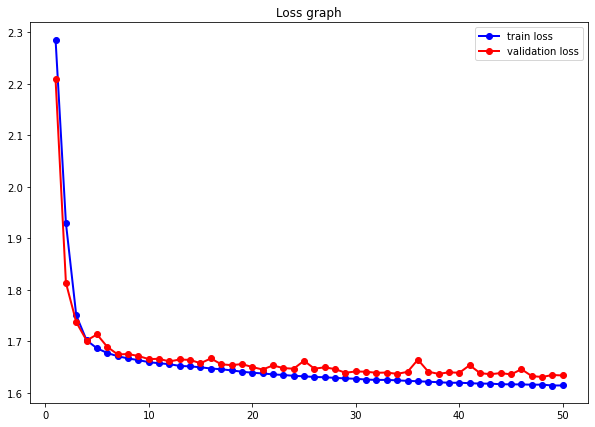

In [12]:
#draw the graph
plt.figure(figsize=(10,7),facecolor='w')
plt.plot(np.array(range(epochs)) + 1.,epochs_training_loss,'o-b',label='train loss',lw =2)
plt.plot(np.array(range(epochs)) + 1.,epochs_val_loss,'o-r',label='validation loss',lw =2)
plt.title('Loss graph')
plt.legend()

we can see that compare the high learning rate graph, the graph looks more smooth, because we set a more lower pace to the gradient descendent process, which means the process may not jump around two sides. Thus, avoiding zigzag moving, the curve looks more smooth.

# 2. Feed in the entire test dataset to the model, to make predictions? Could you write code to do this, and measure your model performance?

In [24]:
testloader1 = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True)

In [25]:

model.eval() # Turn off the model training, begin evaluate
num_right_predict = 0
num_predict = 0

for image, label in testloader1:
    image = image.cuda()
    prediction = model(image)
    prediction = prediction.cpu().detach().numpy()
    if np.argmax(prediction) == label:
        num_right_predict += 1
    num_predict += 1


print('The number of right prediction is {}'.format(num_right_predict))
print('The number of total prediction is {}'.format(num_predict))
print('The accuracy is {}'.format(num_right_predict/num_predict))

The number of right prediction is 7207
The number of total prediction is 10000
The accuracy is 0.7207


In [19]:
len(testloader1)

10000

In [23]:
len(testloader)

157

In [20]:
image.size()

torch.Size([1, 1, 28, 28])

# 3. Train the model on only one epoch?

In [21]:
# Create the custom network above, define the loss criterion, and choose an optimizer to learn weights
model = Classifier()
model = model.to(device)
loss_criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.3)

# Train the network here
epochs = 1

# This two lists is used in graphing.
epochs_training_loss = np.array([], dtype='float64')
epochs_val_loss = np.array([], dtype='float64')

for e in range(epochs):
    print("In epoch", e)
    running_loss = 0
    val_running_loss = 0
    model.train()
    for images, labels in trainloader: # processing one batch at a time
        images, labels = images.to(device),labels.to(device)
        predictions = model(images) # predict labels
        loss = loss_criterion(predictions, labels) # calculate the loss
        
        # BACK PROPAGATION OF LOSS to generate updated weights
        optimizer.zero_grad() # pytorch accumulates gradients from previous backwards
                              # passes by default -- we want to zero them out;
                              # you can read online why they have this implementation choice
        loss.backward() # compute gradients by using the predictions' grad_fn
                        # that was passed to loss_criterion() above -- this is how it
                        # knows what model parameters need updating eventually
                        # (this is confusing IMO and not obvious to those used to OOP)
        optimizer.step() # using gradients just calculated for model parameters, 
                         # update the weights via the optimizer (which was init with those 
                         # model parameters)
        
        running_loss += loss.item()
    print(f"\tTraining loss: {running_loss/len(trainloader)}")
    model.eval()# Turn off the model training, begin evaluate
    for images, labels in testloader:
        # Put the data into GPU
        images, labels = images.to(device), labels.to(device)
        predictions = model(images) # predict labels
        loss_val = loss_criterion(predictions, labels) # calculate the loss
        val_running_loss += loss_val.item()
    
    epochs_training_loss = np.append(epochs_training_loss, running_loss/len(trainloader))
    epochs_val_loss = np.append(epochs_val_loss, val_running_loss/len(testloader))
    print(f"\tValidation loss: {val_running_loss/len(testloader)}")

In epoch 0
	Training loss: 1.8771251836565257
	Validation loss: 1.7418818367514641


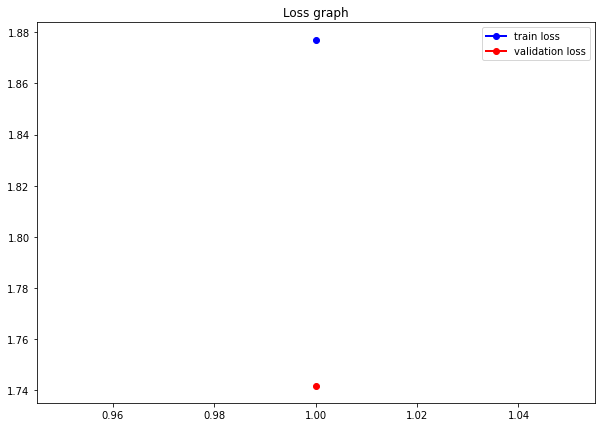

In [22]:
#draw the graph
plt.figure(figsize=(10,7),facecolor='w')
plt.plot(np.array(range(epochs)) + 1.,epochs_training_loss,'o-b',label='train loss',lw =2)
plt.plot(np.array(range(epochs)) + 1.,epochs_val_loss,'o-r',label='validation loss',lw =2)
plt.title('Loss graph')
plt.legend()